# Data Science Job Posting Analysis Assignment

In this assignment we will work with a dataset that incudes information about Data Science scraped from Glassdoor. You will notice that in some cases the prompt in the assignment is a bit vague, and thats okay.

For each prompt write how you tackled the question / data cleaning task and any assumptions you made. Some questions can be interpreted differently and data cleaning can lead to different outcomes, so its perfectly okay for this assignment to have results different from your peers. Thats why its important to note your approach.

This assignment is meant to get you familar with Python, Pandas and visualization libraries (like matplotlib).


## Step 1: Load the Dataset and Import Libraries

This solution uses a synthetic dataset generated in the notebook to demonstrate the analyses. In practice, replace the generation step with `pd.read_csv()` or appropriate loader.

In [1]:
import re
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Load the CSV file (check filename from the print above)
df = pd.read_csv("DataScientist.csv")  # adjust if needed

# Display the first rows of the dataset
print('Dataset overview:')
df.head()

Dataset overview:


,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,TRUE
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


## Step 2: Data Cleaning

You will notice that data cleaning is required for this dataset due to inconsistences.


- Standardize column names (ex. lower case all column names)

- Parse `Salary Estimate` to extract numeric salary values (handle ranges, for example compute the average salary based on the low and high range provided)

- Deduplicate rows if necessary (duplicates are defined as repeated columns in each column)

- Determine columns with too many missing values. Note, some datasets have Nulls for missing values while others might use other characters or notations.

- Standarize job titles. For example, Sr. Data Scientist is equivalent to Senior Data Scientist but we cannot directly compare these two roles without some data cleaning on our part.

### TODO - Your explanations goes here

In [2]:
# Converting the column names to lowercase, and deleting the first two columns
df.rename(columns={column: column.lower() for column in df.columns}, inplace=True)

# deleting the first two columns (redundant index columns) (run this only once)
df = df.drop(columns=df.columns[:2], axis=1)

# We could use the drop_duplicates pandas DataFrame method, but I chose not to since a duplicate posting could pertain to an identical opening but in a different team at the organization, or just a different opening but within the same team.

#### Defining some functions to be used for data cleanup

In [ ]:
def normalize_salary_range(s: str) -> tuple[float, float, str]:
    """Takes the natural language Salary Estimate column values (str) and maps them to the actual lower and upper bounds of the salary range, indicate the time period of the wage.
    
    Example inputs:
    - $73K-$136K (Glassdoor est.)
    - $10-$26 Per Hour(Glassdoor est.)
    - $73.5K-$136.2K (Glassdoor est.)

    Example output:
    - 73000, 136000, 'year'
    - 10, 26, 'hour'
    - 73500, 136200, 'year'"""

    min_salary, max_salary = s.split("-")[:2]
    
    def get_dollar_salary(s: str):
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        salary = float(nums[0])
        if s.index(nums[0]) + len(nums[0]) < len(s):
            if s[s.index(nums[0]) + len(nums[0])] == "K":
                salary *= 1000
            elif s[s.index(nums[0]) + len(nums[0])] == "M":
                salary *= 1000000
            elif s[s.index(nums[0]) + len(nums[0])] == "B":
                salary *= 1000000000
        return salary
    
    min_salary = get_dollar_salary(min_salary)
    max_salary = get_dollar_salary(max_salary)

    if "hour" in s.lower():
        period = "hour"
    else:
        period = "year"

    return (min_salary, max_salary, period)


def salary_range_and_period_to_yearly_est(l: float, h: float, p: typing.Literal["hour", "year"]):
    """Return mean of yearly salary range. In case of hourly wage, assume 260 working days and 8 hours per day.
    
    Params:
        l (float): the lower bound of the salary range
        h (float): the upper bound of the salary range
        p (literal 'hour' or 'year'): the period of the salary figures mentioned"""
    
    return (l + h) / 2 * (8 * 260 if p == "hour" else 1)


def normalize_revenue_range(s: str) -> tuple[float, float, str]:
    """Given the company revenue range in the format present in the dataset, split into lower bound, upper bound, and currency of revenue values."""
        
    s = s.lower()
    
    if "less than" in s:
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        max_revenue = float(nums[0])
        min_revenue = 0
        if "thousand" in s:
            max_revenue *= 1000
        elif "million" in s:
            max_revenue *= 1000000
        elif "billion" in s:
            max_revenue *= 1000000000
        elif "trillion" in s:
            max_revenue *= 100000000000
    elif "+" in s:
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        max_revenue = float('inf')
        min_revenue = float(nums[0])
        if "thousand" in s:
            min_revenue *= 1000
        elif "million" in s:
            min_revenue *= 1000000
        elif "billion" in s:
            min_revenue *= 1000000000
        elif "trillion" in s:
            min_revenue *= 100000000000
    else:
        common_illion = False
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 2, "More or less than 2 numbers found"
        s1, s2 = s.split(" to ")

        r1s = re.findall(number_regex, s1)
        assert len(r1s) == 1, "Too many numbers found"
        min_revenue = float(r1s[0])
        if "thousand" in s1:
            min_revenue *= 1000
        elif "million" in s1:
            min_revenue *= 1000000
        elif "billion" in s1:
            min_revenue *= 1000000000
        elif "trillion" in s1:
            min_revenue *= 100000000000
        else:
            common_illion = True
        
        r2s = re.findall(number_regex, s2)
        assert len(r2s) == 1, "Too many numbers found"
        max_revenue = float(r2s[0])
        if "thousand" in s2:
            max_revenue *= 1000
            common_illion = (1 if not common_illion else 1000)
        elif "million" in s2:
            max_revenue *= 1000000
            common_illion = (1 if not common_illion else 1000000)
        elif "billion" in s2:
            max_revenue *= 1000000000
            common_illion = (1 if not common_illion else 1000000000)
        elif "trillion" in s2:
            max_revenue *= 100000000000
            common_illion = (1 if not common_illion else 1000000000000)
        
        min_revenue *= common_illion
    
    currency_pattern = r"\((.*)\)"
    currencies = re.findall(currency_pattern, s)
    assert len(currencies) == 1, "Could not isolate currency"
    currency = currencies[0].upper()
    
    return min_revenue, max_revenue, currency


def replace_common_abbreviations(s: str) -> str:
    abbrs = {
        "Sr.": "Senior",
        "Sr": "Senior",
        "SR.": "SENIOR",
        "Jr.": "Junior",
        "Jr": "Junior",
        "JR.": "Junior",
        "Dir.": "Director",
        "Dir": "Director",
        "DIR.": "Director",
    }
    s = s.split(" ")
    for i, w in enumerate(s):
        for abbr, full in abbrs.items():
            if w == abbr:
                s[i] = full
    return " ".join(s)

def job_title_cleaner(s: str) -> str:
    """Cleans job titles by:
    - Replacing common job title abbreviations
    - Removing text after a comma
    - Removing text after a hyphen
    - Removing text in parantheses"""

    return replace_common_abbreviations(s).split(", ")[0].split(" - ")[0].split(" (")[0]

#### Some case-by-case cleaning on individual columns

1. Replacing `-1`s with `None`s
    1. `Rating`
        Clearly, the -1 rating indicates that a rating does not exist for a company, since user ratings are measured between 1-5.
    2. `Headquarters`
    3. `Size`
        Obviously, -1 size does not indicate that negative one person works at the company, None would be better suited here.
    4. `Founded`
    6. `Industry`
    7. `Sector`
2.  Replacing `Unknown`s with `None`s
    1. `Type of Ownership`
3. Replacing `Unknown / Non-Applicable`s with `None`s
    1. `Revenue`
4. Converting the `Competitors` column into a list
5. Replacing `-1`s in `Easy Apply` with `False`, and `'TRUE'` with `True`
6. Some company names include their rating in the next line; removing them.
7. Cleaning job titles (into a new column to avoid data loss)
    1. Expanding common abbreviations in job titles
    2. Removing text after a comma (ex. `Sr Software Engineer, Python`)
    3. Removing text after a hyphen (ex. `Data Scientist - Forecasting`)
    4. Removing text in parantheses (ex. `Data Scientist/Engineer (SAS, R code, Python & Sql (Open to remote Workers))`)

In [25]:
df['rating'] = df['rating'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['headquarters'] = df['headquarters'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['size'] = df['size'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['founded'] = df['founded'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['industry'] = df['industry'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['sector'] = df['sector'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)

df['type of ownership'] = df['type of ownership'].replace(to_replace="Unknown", value=None)

df['revenue'] = df['revenue'].replace(to_replace="Unknown / Non-Applicable", value=None).replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)

df['competitors'] = df['competitors'].replace(to_replace=-1, value='').replace(to_replace='-1', value='')
df['competitors'] = df['competitors'].apply(func=lambda x: [c for c in x.split(", ") if c] if isinstance(x, str) else x)

df['easy apply'] = df['easy apply'].replace(to_replace=-1, value=False).replace(to_replace='-1', value=False).replace(to_replace='TRUE', value=True)

df['company name'] = df['company name'].apply(func=lambda x: x.split("\n")[0])

df['cleaned job title'] = df['job title'].apply(func=job_title_cleaner)

df

,cleaned job title,location,lower salary bound,upper salary bound,salary per,average annual salary estimate,company name,type of ownership,industry,sector,...,founded,revenue range lower bound,revenue range upper bound,revenue currency,job description,rating,easy apply,job title,salary estimate,revenue
0,Senior Data Scientist,"New York, NY",111000.0,181000.0,year,146000.0,Hopper,Company - Private,Travel Agencies,Travel & Tourism,...,2007,NaN,NaN,None,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,False,Senior Data Scientist,$111K-$181K (Glassdoor est.),None
1,Data Scientist,"New York, NY",111000.0,181000.0,year,146000.0,Noom US,Company - Private,"Health, Beauty, & Fitness",Consumer Services,...,2008,NaN,NaN,None,"At Noom, we use scientifically proven methods ...",4.5,False,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),None
2,Data Science Manager,"New York, NY",111000.0,181000.0,year,146000.0,Decode_M,None,None,None,...,None,NaN,NaN,None,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,None,True,Data Science Manager,$111K-$181K (Glassdoor est.),None
3,Data Analyst,"Lyndhurst, NJ",111000.0,181000.0,year,146000.0,Sapphire Digital,Company - Private,Internet,Information Technology,...,2019,NaN,NaN,None,Sapphire Digital seeks a dynamic and driven mi...,3.4,False,Data Analyst,$111K-$181K (Glassdoor est.),None
4,Director,"New York, NY",111000.0,181000.0,year,146000.0,United Entertainment Group,Company - Private,Advertising & Marketing,Business Services,...,2007,NaN,NaN,None,"Director, Data Science - (200537)\nDescription...",3.4,False,"Director, Data Science",$111K-$181K (Glassdoor est.),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,AWS Data Engineer,"Dublin, OH",55000.0,112000.0,year,83500.0,Tachyon Technologies,Company - Private,IT Services,Information Technology,...,2011,1.000000e+07,2.500000e+07,USD,About Us\n\nTachyon Technologies is a Digital ...,4.4,False,AWS Data Engineer,$55K-$112K (Glassdoor est.),$10 to $25 million (USD)
3905,Data Analyst â Junior,"Columbus, OH",55000.0,112000.0,year,83500.0,"Staffigo Technical Services, LLC",Company - Private,IT Services,Information Technology,...,2008,5.000000e+07,1.000000e+08,USD,"Job description\nInterpret data, analyze resul...",5.0,False,Data Analyst â Junior,$55K-$112K (Glassdoor est.),$50 to $100 million (USD)
3906,Security Analytics Data Engineer,"Dublin, OH",55000.0,112000.0,year,83500.0,"PDS Tech, Inc.",Company - Private,Staffing & Outsourcing,Business Services,...,1977,1.000000e+08,5.000000e+08,USD,Job DescriptionThe Security Analytics Data Eng...,3.8,False,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),$100 to $500 million (USD)
3907,Security Analytics Data Engineer,"Dublin, OH",55000.0,112000.0,year,83500.0,Data Resource Technologies,Company - Private,Accounting,Accounting & Legal,...,None,0.000000e+00,1.000000e+06,USD,The Security Analytics Data Engineer will inte...,4.0,False,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Less than $1 million (USD)


#### Adding columns extracted from other columns

1. `Salary Estimate` → `Lower Salary Bound`, `Upper Salary Bound`, `Salary Per`, `Estimated Annual Salary`

In [6]:
df['lower salary bound'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[0] if isinstance(x, str) else x)
df['upper salary bound'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[1] if isinstance(x, str) else x)
df['salary per'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[2] if isinstance(x, str) else x)
df.loc[df['salary per'] == 'year', 'average annual salary estimate'] = salary_range_and_period_to_yearly_est(df[df['salary per'] == 'year']['lower salary bound'], df[df['salary per'] == 'year']['upper salary bound'], 'year')
df.loc[df['salary per'] == 'hour', 'average annual salary estimate'] = salary_range_and_period_to_yearly_est(df[df['salary per'] == 'hour']['lower salary bound'], df[df['salary per'] == 'hour']['upper salary bound'], 'hour')

df['revenue range lower bound'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[0] if isinstance(x, str) else x)
df['revenue range upper bound'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[1] if isinstance(x, str) else x)
df['revenue currency'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[2] if isinstance(x, str) else x)

df[["cleaned job title", "salary estimate", "lower salary bound", "upper salary bound", "salary per", "company name", "revenue", "revenue range lower bound", "revenue range upper bound", "revenue currency"]].dropna(inplace=False)

,cleaned job title,salary estimate,lower salary bound,upper salary bound,salary per,company name,revenue,revenue range lower bound,revenue range upper bound,revenue currency
11,Data Scientist/Machine Learning,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,PulsePoint,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
12,"Data Scientist, Acorn AI Labs",$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Medidata Solutions,$500 million to $1 billion (USD),5.000000e+08,1.000000e+09,USD
16,"Data Scientist, Analytics",$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Etsy,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
17,Data Scientist/ML Engineer,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,PA Consulting,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
18,Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Etsy,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
...,...,...,...,...,...,...,...,...,...,...
3904,AWS Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,Tachyon Technologies,$10 to $25 million (USD),1.000000e+07,2.500000e+07,USD
3905,Data Analyst â Junior,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,"Staffigo Technical Services, LLC",$50 to $100 million (USD),5.000000e+07,1.000000e+08,USD
3906,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,"PDS Tech, Inc.",$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
3907,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,Data Resource Technologies,Less than $1 million (USD),0.000000e+00,1.000000e+06,USD


#### Reordering columns for more clarity

In [18]:
desired_column_order = [
    "cleaned job title",
    "location",
    "lower salary bound",
    "upper salary bound",
    "salary per",
    "average annual salary estimate",
    "company name",
    "type of ownership",
    "industry",
    "sector",
    "competitors",
    "headquarters",
    "size",
    "founded",
    "revenue range lower bound",
    "revenue range upper bound",
    "revenue currency",
    "job description",
    "rating",
    "easy apply",
    "job title",
    "salary estimate",
    "revenue",
]
df = df[desired_column_order]

In [19]:
df.to_csv("ProcessedDataScientist.csv")

PermissionError: [Errno 13] Permission denied: 'ProcessedDataScientist.csv'

## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Basic Overview
What are the top or most popular job titles?
What are the top companies (based on job posting)?
What are the top 5 industry sectors (based on job postings)?

We see that the top 10 job titles based on the input dataset are:
- Data Scientist
- Data Engineer
- Data Analyst
- Senior Data Scientist
- Machine Learning Engineer
- Senior Data Analyst
- Big Data Engineer
- Business Intelligence Analyst
- Senior Data Engineer
- Sr. Data Scientist

After merging jobs by expanding abbreviations (Jr, Sr, etc.) in job titles and applying other title cleaning methods, we notice that the top 10 are now different:
- Data Scientist
- Data Engineer
- Data Analyst
- Senior Data Scientist
- Senior Data Analyst
- Senior Data Engineer
- Machine Learning Engineer
- Scientist
- Senior Scientist
- Big Data Engineer

There are still some job titles (examples listed below) whose successful normalization could have affected the top 10.
- Data Scientist/Machine Learning
- AWS Data Engineer

Here is a pie chart that shows the distribution of the top 5 job titles in the dataset:


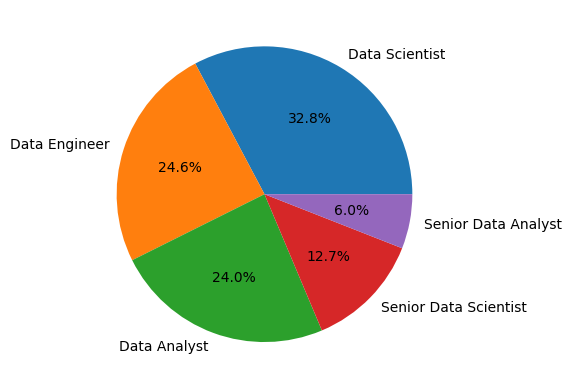

In [ ]:
# Top job titles (look at 'Job Title' column). Generate a plot to visualize top 5 job titles based on the number of postings for that same job title.
top_job_titles_dict = df["job title"].value_counts().to_dict()  # in descending order of frequency
n = 10
print(f"We see that the top {n} job titles based on the input dataset are:\n- " + "\n- ".join(list(top_job_titles_dict.keys())[:n]), end="\n\n")
top_cleaned_job_titles_dict = df["cleaned job title"].value_counts().to_dict()
print(f"After merging jobs by expanding abbreviations (Jr, Sr, etc.) in job titles and applying other title cleaning methods, we notice that the top {n} are now different:\n- " + "\n- ".join(list(top_cleaned_job_titles_dict.keys())[:n]), end="\n\n")
print(f"There are still some job titles (examples listed below) whose successful normalization could have changed the top {n}.\n- Data Scientist/Machine Learning\n- AWS Data Engineer", end="\n\n")
n = 5
print(f"Here is a pie chart that shows the distribution of the top {n} job titles in the dataset:")
labels = list(top_cleaned_job_titles_dict.keys())[:n]  # + ["Others"]
sizes = list(top_cleaned_job_titles_dict.values())[:n]  # + [sum(list(top_cleaned_job_titles_dict.values())[n:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.show()

Here is a pie chart that shows the distribution of the top 5 companies posting jobs in the dataset:


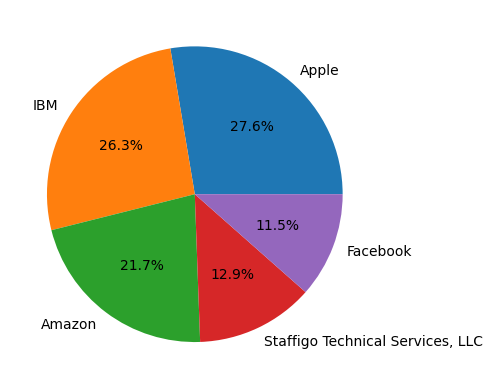

In [54]:
# Top companies (look at 'Company Name' column). Generate a plot to visualize top 5 companies based on the number of job postings.
top_companies_dict = df["company name"].value_counts().to_dict()
labels = list(top_companies_dict.keys())[:5]  # + ["Others"]
sizes = list(top_companies_dict.values())[:5]  # + [sum(list(top_companies_dict.values())[5:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
print("Here is a pie chart that shows the distribution of the top 5 companies posting jobs in the dataset:")
plt.show()

Here is a pie chart that shows the distribution of the top 5 industries with jobs being posted in the dataset:


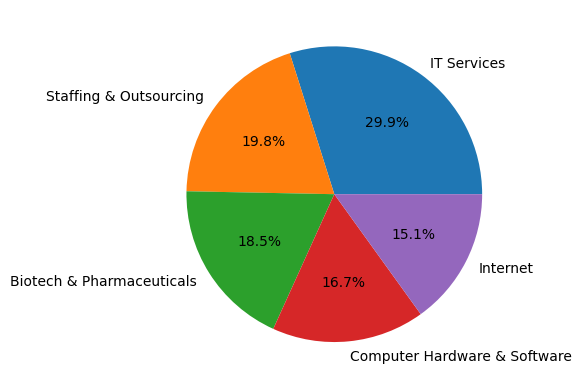

In [53]:

# Top Industry (look at 'Industry' column). Generate a plot to visualize top 5 industries based on the number of job postings linked to that industry.
top_industries_dict = df["industry"].value_counts().to_dict()
labels = list(top_industries_dict.keys())[:5]  # + ["Others"]
sizes = list(top_industries_dict.values())[:5]  # + [sum(list(top_industries_dict.values())[5:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
print("Here is a pie chart that shows the distribution of the top 5 industries with jobs being posted in the dataset:")
plt.show()

TODO - Your findings goes here

### 3.2 Salary Analysis
Distribution, central tendency, and top-paying job titles. Print out the mean, median and mode for job salaries. Generate a plot that shows salary distribution (this can be done for all positions collectively).

In [ ]:
# TODO - your code goes here
mean = df

TODO - Findings (if any) goes here

### 3.3 Remote vs. In-Person Jobs

Some job descriptions note that 'Work Remotely: Yes' which we can assume means this position is fully remote. Lets compare salary ranges for remote vs in-person positions for equivalent job titles.

You don't need to do this for all job titles, but select a few job titles that have a remote and in-person postings and compare their salary range.

Note, it will probably help to first create a new column that denotes if a posting is a remote or in-person job by parsing the job description for hints about remote work.

In [ ]:
# TODO - your code goes here

TODO - Findings (if any) goes here

### 3.4 Location Distribution
Top locations and salary comparisons across locations.

- Perform analysis and visualize job postings by location. What are your findings?
- Visualize salary (for equivalent positions) by location. What are your findings?

In [ ]:
# TODO - your code goes here

TODO - Findings (if any) goes here

### 3.5 Skills Analysis

To make this part easier, focus on the 'Data Scientist' job title.

Count frequency of tools/skills across job postings (ex. Hadoop, Spark, Python, R, Tableau, BigData, Pytorch, etc.). What technology / skills should I be teaching in my DS courses to meet the demand from industry?

You can parse the job description and look for specific skills / tools. Consider creating new columns that denote whether a job posting explicitly mentions that skill set. You can then use these columns to evaluate which skills / tools are sought out in industry.

In [ ]:
# TODO - Code goes here

TODO - Findings (if any) goes here

### 3.6 Analysis
Is there any correlation between the type of  industry and the number of jobs and the salary range for those jobs? Generate some plots.

In [ ]:
# TODO - Code goes here

TODO - Findings (if any) goes here

## Step 4: More EDA
Example: Compare salary trends across seniority inferred from job title (entry vs senior). For each job posting, characterize job as either senior, mid or entry. Then determine salary range for each postion. Generate a plot to show how salaries compare.

In [ ]:
# TODO - Code goes here

TODO - Findings (if any) goes here

## Step 5: Reflection

**Challenges faced:**  TODO

**Key findings:**
TODO